In [2]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed

# Progress bar for simulation
def progressBar(c,m,l) : # c - done iterations, m - all iterations, l - length of bar
    done = int(np.ceil(c / m * l)) # filled part
    notDone = l - done # remaining part
    print('[' + '#' * done + ' ' * notDone + '] ' + f'{c / m * 100 : .2f}%', end='\r') # showing bar with percentage

# Getting nearest neighbors of site (x,y) in system
def getNeighbors(system, x, y) :
    return [system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < system.shape[0] and j < system.shape[1]]

In [3]:
# Class describing state of single site in system - description of culture of given village
class Site() :  

    '''
    It is created as a class because if we want change it somehow, we don't need to rewrite whole code, but can create a second class inheriting from it, e.g.:
    
    class Site2(Site) :
        def probabilityOfInteraction(self, other: object) :
            if self._n_features != other._n_features or self._n_traits != other._n_traits : 
                raise Exception('Sizes of features do not agree')
            else :
                return 1 - np.equal(self._values, other._values).sum() / self._n_features

    Every aspect and method of original class stays the same, but now probability of interaction is reversed, so the more differences, the higher chance
    of interaction. They are crusaders now. Other idea is to add some another value describing the terrain of a site that will influence the probability of
    interaction.
    '''

    # Constructor of class
    def __init__(self, n_features: int = 5, n_traits: int = 10, values: np.array = None) : 
        # n_features - number of features, n_traits - number of possible traits per features, values -  we can set our own values of features
        # Assigning fields of class
        self._n_features = n_features
        self._n_traits = n_traits
        # If we do not specify values, they are generated randomly
        if values is None : 
            self._values = np.random.choice(range(n_traits), n_features)
        elif len(values) != n_features or np.any([x > self._n_traits for x in values]) : # Checking consistency of input
            raise Exception('Given values do not agree with number of features or traits') 
        else : 
            self._values = np.array(values)

    ## Conversion to string - presenting values as string, e.g. [1,2,3,4,5]->'1,2,3,4,5'
    def __str__(self) :
        return ','.join([str(x) for x in self._values])

    ## Same as above, needed for jupyter outputs (without prints)
    def __repr__(self) : 
        return self.__str__()

    def __hash__(self) :
        return hash(self.__str__())

    # Getter for values
    def getValues(self) :
        return self._values

    # Getter for n_features and n_traits
    def getSize(self) : 
        return self._n_features, self._n_traits
        
    # Calculationg probability of interaction between two sites, e.g. site1.probabilityOfInteraction(site2)
    def probabilityOfInteraction(self, other: object) :
        if self._n_features != other._n_features: 
            raise Exception('Sizes of features do not agree') # Checking consistency of input
        else : # Probability is ratio of common features to all features
            return np.equal(self._values, other._values).sum() / self._n_features 
    
    # Interaction between sites, returns updated initial site, e.g. site1 = site1.interaction(site2) - updating of site1 features
    def interact(self, other: object) :
        if self._n_features != other._n_features: 
            raise Exception('Sizes of features do not agree') # Checking consistency of input
        else :
            # Indexes of features with different traits
            differentFeatures = np.arange(0,self._n_features)[np.not_equal(self._values, other._values)]
            if len(differentFeatures) > 0 : # If there are any different features
                index = np.random.choice(differentFeatures,1) # We choose randomly one of them
                newValues = self._values.copy() # Copy initial values
                newValues[index] = other._values[index] # Change chosen feature's trait to the one from the other trait
                return Site(self._n_features, max(self._n_traits,other.getSize()[1]), newValues) # Return new Features object 
            else :
                return self # If sites are identical, return one of them

In [4]:
class BasicAxelrodModel() :
    # Constructor of class
    def __init__(self, L: int = 10, n_features: int = 5, n_traits: int = 8, site_class = Site, seed: int = None) :
        # L - size of lattice (here lattice is square 2D LxL), n_features, n_traits - parameters passed to Site constructor,
        # site_class - here we pass class of our site, if we make some extension of it, seed - seed for RNG
        
        np.random.seed(seed) # Reseting RNG

        # Assigning fields of clas
        self.L = L
        self.n_traits = n_traits
        self.n_features = n_features
        self._site_class = site_class
        self._system = np.empty((L,L)) # System is initially an empty 2D-array 
    
    # Initializing a system system
    def createSystem(self) :
        # Generator - a function asssinging to each element of system a new instance of Site class with given parameters
        generator = np.vectorize(lambda _ : self._site_class(self.n_features,self.n_traits))
        # Creting a system
        self._system = generator(self._system)

    def getNeighbors(self, x, y) :
        return [self._system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < self.L and j < self.L]

    # Getter for system
    def getSystem(self) :
        return self._system.copy()

    # Simulate the system
    def simulate(self, MCS: int = 10000, N: int = 1, verbose: bool = False, progress = True) :
        # MCS - number of Monte Carlo / time steps, N - number of events in every time step, verbose - printing addition info, progress - prinitng progress bar
        
        # Loop over time steps
        for step in range(MCS) :
            # Loop over events per step
            for event in range(N) :
                # Progress bar
                if not(verbose) and progress :
                    progressBar(step*N+event, MCS*N, 50)

                # Choosing random coordinates in system
                x, y = np.random.randint(0,self.L,2)
                # Getting the site on these coordinates
                site1 = self._system[x, y]
                # Finding neifghbors of this site
                neighbors = getNeighbors(self._system,x,y)#[self.__system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < self.L and j < self.L]
                # Randomly choosing one of the neighbors
                site2 = np.random.choice(neighbors)
                # Calculating probability of interaction between site1 and site2
                p = site1.probabilityOfInteraction(site2)
                
                if verbose :
                    print((x,y), (site1,site2), p)
                
                # Testing if interaction happens
                if np.random.rand() < p :
                    # Updating site1 in system 
                    self._system[x, y] = site1.interact(site2)
                    if verbose : 
                        print(self._system[x,y])

    def simulateUntilStable(self, limit = 1000000, step=10000, progress = False):
        regions = self.L * self.L
        for i in range(0,limit,step):
            if progress:
                print(f'{i}', end='\r')
            self.simulate(step,1,False,False)
            tmp = self.countRegions()
            if self.checkStability():
                return i
            else:
                regions = tmp
        return -1

    def getRegions(self) :
        d = {} # Dictionary of regions
        ctr = 0
        for i in range(self.L) : # Iteration over cols
            for j in range(self.L) : # Iteration over rows
                v = hash(self._system[i,j]) # Get unique value of site
                if v not in d.keys() : # If doesn't exist in dictionary
                    ctr += 1
                    d[v] = (ctr, 1)
                else:
                    d[v] = (d[v][0], d[v][1]+1)

        return dict(d.values())


    def countRegions(self) :
        x = len(np.unique(np.vectorize(lambda x: str(x))(self._system).flatten()))
        return x


    def checkStability(self):
        for x in range(self.L):
            for y in range(self.L):
                n = self.getNeighbors(x, y)
                for s in n:
                    p = self._system[x,y].probabilityOfInteraction(s) 
                    if p > 0 and p < 1:
                        return False
        return True

    # Plotting map of system with distinct colors for distinct features
    def plotMap(self,cmap='binary') :
        d = {} # Dictionary of regions
        ctr = 0 # Counter of regions
        map = np.zeros((self.L,self.L)) # Map
        for i in range(self.L) : # Iteration over cols
            for j in range(self.L) : # Iteration over rows
                v = hash(self._system[i,j]) # Get unique value of site
                if v in d.keys() : # If exists in dictionary
                    map[i,j] = d[v] # Add to map
                else : # Else add to dictionary and add to map
                    ctr +=1
                    d[v] = ctr
                    map[i,j] = ctr
        
        plt.imshow(map,cmap=cmap)
        return map

    # Plotting map of the system
    def plotBorders(self, withColorbar = False, withTicks = False):
        # Map is 4 times bigger than system, because we need to plot borders so s1,s2,s3 -> s1,b12,s2,b23,s3 etc
        map = np.ones((2*self.L-1, 2*self.L-1)) # Initially we set all elements as 1, because we will plot probability of interaction
        # and thanks to this elements with villages will have the same value as border between identical sites and, in the end, the same color on plot
        
        # Loop over cols
        for i in range(self.L) :
            # Loop over rows
            for j in range(self.L) :
                # If we are not in last col
                if i < self.L-1 :
                    # We calculate probability of interaction between sites in two columns
                    p1 = self._system[i,j].probabilityOfInteraction(self._system[i+1,j])
                    # And map it 
                    map[2*i+1,2*j] = p1
                # If we are not in the last row
                if j < self.L-1 :
                    # We calculate probability of interaction between sites in two rows
                    p2 = self._system[i,j].probabilityOfInteraction(self._system[i,j+1])
                    # And map it
                    map[2*i,2*j+1] = p2

        # Additional loop assigning values to corner borders as minimal value of its neighbors - regular borders
        for i in range(self.L) :
            for j in range(self.L) :
                if i < self.L-1 and j < self.L-1 :
                    map[2*i+1,2*j+1] = np.min(getNeighbors(map,2*i+1,2*j+1))

        # Plotting the map: white color is villages and no borders (p=1), black colors are strict borders (p=1)
        plt.imshow(map,plt.cm.get_cmap('gray'))

        # Relabeling ticsk to point only villages
        if withTicks:
            plt.xticks(np.arange(0,2*self.L,2*(self.L//10)),np.arange(0,self.L,self.L//10))
            plt.yticks(np.arange(0,2*self.L,2*(self.L//10)),np.arange(0,self.L,self.L//10))
        else:
            plt.xticks([])
            plt.yticks([])
            
        if withColorbar:
            plt.colorbar()
        plt.clim(0,1)
            
        return map

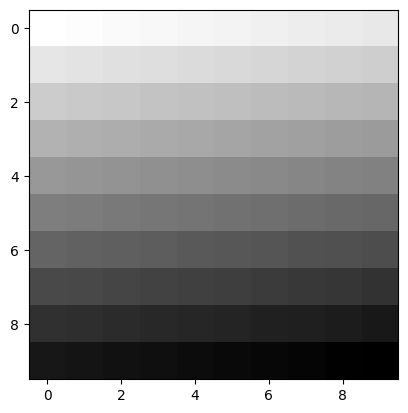

[]

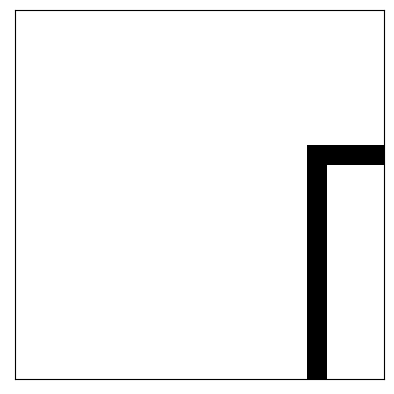

In [4]:
# Example of performing basic simulation
m = BasicAxelrodModel(L=10) # We create a model with our parameters
m.createSystem() # We initialize system
m.plotMap() # Plotting the map before simulation
plt.show()
m.simulate(MCS=60000) # Performing simulation
m.plotBorders() # Plotting the map after simulation
plt.plot()


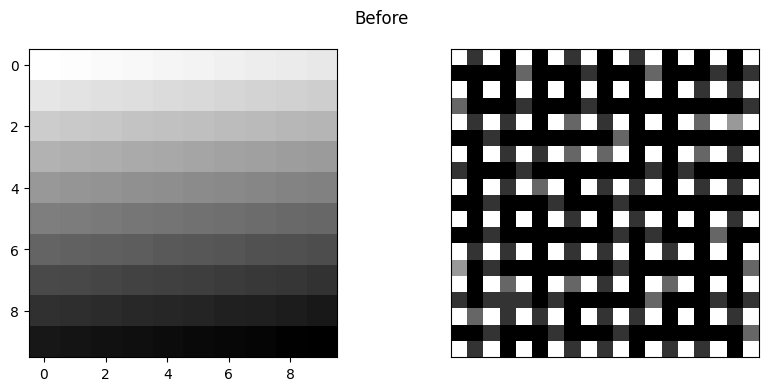

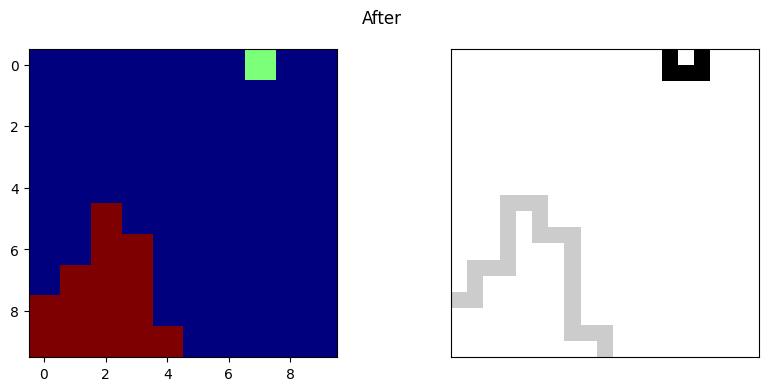

In [5]:
x = BasicAxelrodModel(L=10,seed=692137)
x.createSystem()
plt.figure(figsize=(10,4))
plt.suptitle('Before')
plt.subplot(1,2,1)
x.plotMap()
plt.subplot(1,2,2)
x.plotBorders()
plt.show()
x.simulate(80000)
plt.figure(figsize=(10,4))
plt.suptitle('After')
plt.subplot(1,2,1)
a = x.plotMap('jet')
plt.subplot(1,2,2)
b = x.plotBorders()
plt.show()

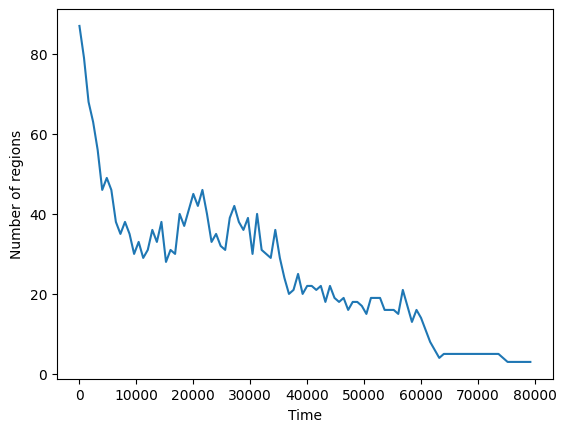

In [6]:
x = BasicAxelrodModel(seed=692137)
x.createSystem()
c = []
for i in range(100): 
    progressBar(i,100,10)
    x.simulate(800,progress=False)
    c.append(x.countRegions())

plt.plot(np.arange(0,80000,800),c)
plt.xlabel('Time')
plt.ylabel('Number of regions')
plt.show()

## Cultural drift

In [5]:
# Child class of Site used for the Axelrod model with cultural drift simulation 
class SpontaneousSite(Site):
    '''
    Implements the new "drift" method and modifies:
    interact - to account for the new site type
    '''

    def __init__(self, n_features: int = 5, n_traits: int = 10, values: np.array = None, spontan_prob: float = 0.0):
        super().__init__(n_features, n_traits, values)
        self._spontan_prob = spontan_prob

    # With probability _spontan_prob randomly change one of the features
    def drift(self):
        threshold = np.random.random() # Generate a random threshold to compare 
        if(threshold<=self._spontan_prob): # With some p find a random feature and change it to a random trait
            new_val = np.random.choice(a=range(self._n_traits), size=1)
            index = np.random.choice(a=range(0,self._n_features), size=1)
            new_values = self._values
            new_values[index] = new_val
            return SpontaneousSite(self._n_features,self._n_traits,new_values,self._spontan_prob) # If feature changed return a new SpontaneousSite object
        else:
            return self # If feature not changed return itself

    # Interaction between sites, returns updated initial site, e.g. site1 = site1.interaction(site2) - updating of site1 features
    # Return value changed from original Site object to SpontaneousSite object
    def interact(self, other: object) :
        if self._n_features != other._n_features or self._n_traits != other._n_traits : 
            raise Exception('Sizes of features do not agree') # Checking consistency of input
        else :
            # Indexes of features with different traits
            differentFeatures = np.arange(0,self._n_features)[np.not_equal(self._values, other._values)]
            if len(differentFeatures) > 0 : # If there are any different features
                index = np.random.choice(differentFeatures,1) # We choose randomly one of them
                newValues = self._values.copy() # Copy initial values
                newValues[index] = other._values[index] # Change chosen feature's trait to the one from the other trait
                return SpontaneousSite(self._n_features, self._n_traits, newValues,self._spontan_prob) # Return new Site object 
            else :
                return self # If sites are identical, return one of them


In [6]:
# Child class of the BasicAxelrodModel, performs the simulation with cultural drift phenomenon
class SpontainousAxelrodModel(BasicAxelrodModel):
    '''
    Implements the Axelrod model with cultural drift and modifies:

    createSystem - generator function now generates a grid of SpontaneousSite objects
    simulate - calls the drift method in each MC step
    '''

    def __init__(self, L: int = 10, n_features: int = 5, n_traits: int = 8, site_class = SpontaneousSite, seed: int = None,verbose=False, spontaneous_p: float = 1):
        super().__init__(L, n_features, n_traits, seed,verbose)
        self._site_class = site_class
        self._spontaneous_p = spontaneous_p # Probability of a random change in features
        self._system = np.empty((L,L)) # System is initially an empty 2D-array 
    

    # generator chagned to now generate a SpontaneousSite object with probability of drift
    def createSystem(self) :
        # Generator - a function asssinging to each element of system a new instance of Site class with given parameters
        generator = np.vectorize(lambda _ : self._site_class(self.n_features,self.n_traits, spontan_prob=self._spontaneous_p))
        # Creting a system
        self._system = generator(self._system)

    # Simulate the system
    # Function changed to prerform .drift() method
    def simulate(self, MCS: int = 10000, N: int = 1, verbose: bool = False, progress = True) :
        # MCS - number of Monte Carlo / time steps, N - number of events in every time step, verbose - printing addition info, progress - prinitng progress bar
        
        # Loop over time steps
        for step in range(MCS) :
            # Loop over events per step
            for event in range(N) :
                # Progress bar
                if not(verbose) and progress :
                    progressBar(step*N+event, MCS*N, 50)

                # Choosing random coordinates in system
                x, y = np.random.randint(0,self.L,2)

                # Getting the site on these coordinates

                site1 = self._system[x, y]

                # Chance for a spontaneous change in trait - cultural drift
                site1 = site1.drift()

                # Finding neifghbors of this site
                neighbors = getNeighbors(self._system,x,y)#[self._system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < self.L and j < self.L]
                # Randomly choosing one of the neighbors
                site2 = np.random.choice(neighbors)
                # Calculating probability of interaction between site1 and site2
                p = site1.probabilityOfInteraction(site2)
                
                if verbose :
                    print((x,y), (site1,site2), p)
                
                # Testing if interaction happens
                if np.random.rand() < p :
                    # Updating site1 in system 
                    self._system[x, y] = site1.interact(site2)
                    if verbose : 
                        print(self._system[x,y])

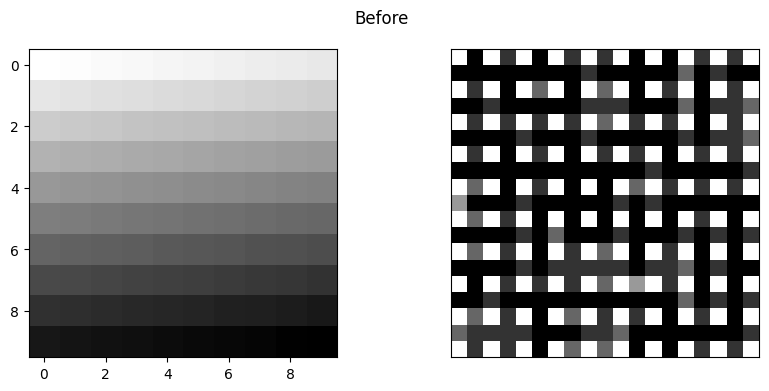

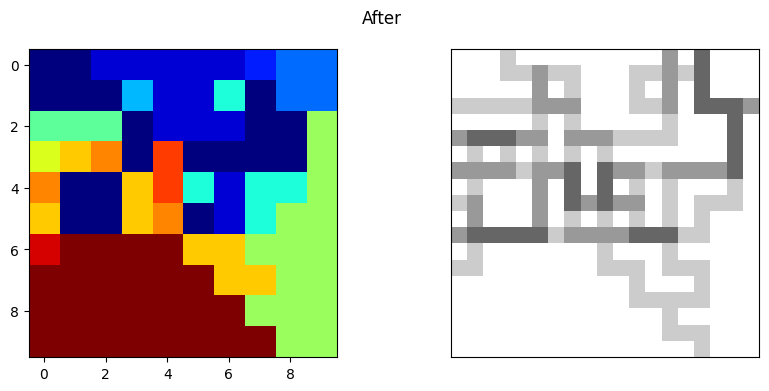

In [9]:
# Example of the simulation with the cultural drift model
x = SpontainousAxelrodModel(L=10,seed=692137,spontaneous_p=0.015)
x.createSystem()
plt.figure(figsize=(10,4))
plt.suptitle('Before')
plt.subplot(1,2,1)
x.plotMap()
plt.subplot(1,2,2)
x.plotBorders()
plt.show()
x.simulate(80000)
plt.figure(figsize=(10,4))
plt.suptitle('After')
plt.subplot(1,2,1)
a = x.plotMap('jet')
plt.subplot(1,2,2)
b = x.plotBorders()
plt.show()

In [7]:
c = np.zeros(100)
M = 20

for _ in range(M):
    x = SpontainousAxelrodModel(10,5,10,spontaneous_p=0.01)
    x.createSystem()
    for i in range(100): 
        progressBar(i,100,10)
        x.simulate(1000,progress=False)
        c[i] += x.countRegions()

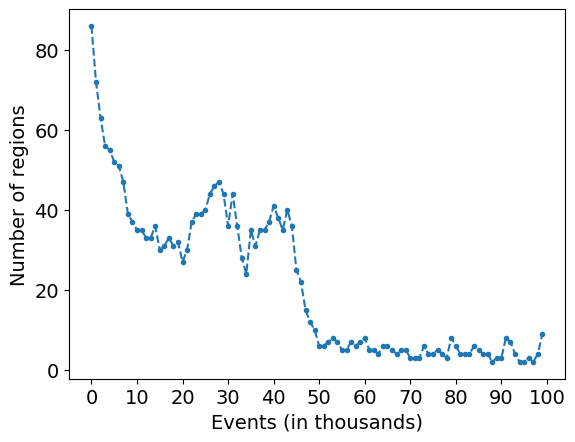

In [9]:
plt.rcParams.update({'font.size': 14})
plt.plot(np.arange(0,100000,1000),c/M,'.--')
plt.xlabel('Events (in thousands)')
plt.ylabel('Number of regions')
plt.xticks(np.arange(0,1e5+1,1e4),np.arange(0,101,10))
plt.show()

In [11]:
ps = np.arange(0,0.02,0.001)
ps2 = np.random.permutation(ps)
r = np.zeros(len(ps))

def process(p):
    M = 10
    r = 0
    for _ in range(M):
        x = SpontainousAxelrodModel(10,5,10,spontaneous_p=p)
        x.createSystem()
        r += x.simulateUntilStable(10000000,25000)
    return r / M

results = Parallel(4)(delayed(process)(p) for p in ps2)

In [ ]:
z = np.array((sorted(zip(ps2,results),key=lambda x: x[0])))
np.savetxt('drift_p_stability_time_F5_q10.txt',z)
plt.plot(ps2,results,'o')
plt.show()

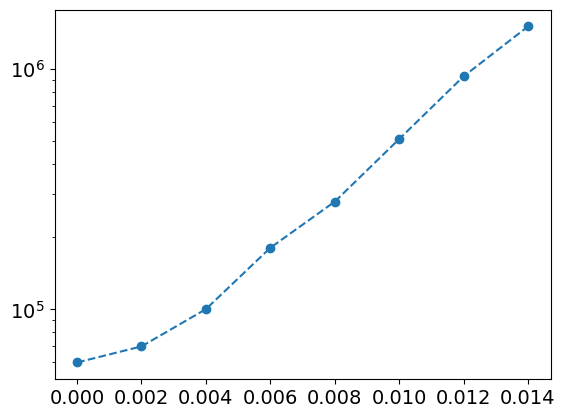

In [10]:
p1 = np.loadtxt('drift_p_stability_time_F5_q10.txt')
plt.plot(p1[:,0],p1[:,1],'o--')
plt.yscale('log')
plt.show()

In [64]:
qs = np.arange(4,40,4)
D = np.zeros(len(qs))
nD = np.zeros(len(qs))
M = 10
L = 10

def process(q):
    print(q)
    res1 = 0
    res2 = 0
    for _ in range(M):
        m = SpontainousAxelrodModel(L,5,q,spontaneous_p=0.008)
        m.createSystem()
        m.simulateUntilStable()
        tmp = m.getRegions()
        res1 += max(tmp.values())
        res2 += len(tmp)
    return res1, res2

results = Parallel(n_jobs=4)(delayed(process)(q) for q in qs)

In [65]:
results

[(1000, 10),
 (1000, 10),
 (1000, 10),
 (1000, 10),
 (1000, 10),
 (940, 30),
 (780, 110),
 (340, 190),
 (950, 40)]

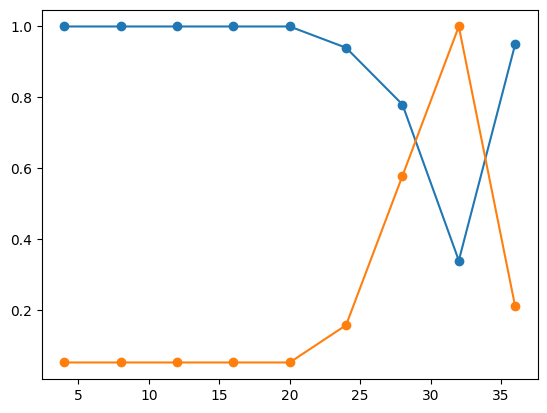

In [67]:
D = np.array(results,np.float64)[:,0]
nD = np.array(results,np.float64)[:,1] 
D /= max(D)
nD /= max(nD)

import pandas as pd
x = pd.DataFrame({'q':qs, 'D':D, 'nD': nD})
x.to_csv('spon0.008_phasetrans_L5_F5_M80.csv')

plt.plot(qs,D,'o-')
plt.plot(qs,nD,'o-')
plt.show()

In [ ]:
m = SpontainousAxelrodModel(10,5,10,seed=1,spontaneous_p=0.01)
m.createSystem()


plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
plt.subplot(2,2,1)
m.plotBorders()
plt.title('a) At start')

plt.subplot(2,2,2)
m.simulate(20000)
m.plotBorders()
plt.title('b) After 20,000 events')

plt.subplot(2,2,3)
m.simulate(20000)
m.plotBorders()
plt.title('c) After 40,000 events')

plt.subplot(2,2,4)
m.simulate(40000)
m.plotBorders()
plt.title('d) After 80,000 events')

plt.show()

## Technological development

In [11]:
class DevelopingSite(Site) :  
    '''
    Site with modified interacion function to account for trait attractiveness 
    '''
    # Interaction between sites, returns updated initial site, e.g. site1 = site1.interaction(site2) - updating of site1 features
    def interact(self, other: object) :
        if self._n_features != other._n_features: 
            raise Exception('Sizes of features do not agree') # Checking consistency of input
        else :
            # Attractiveness of feature is equal to feature number
            differentFeatures = np.array(other._values[np.not_equal(self._values, other._values)]) + 1 # Add one to solve the NaN problem later

            if len(differentFeatures) > 0 : # If there are any different features

                differentFeatures = differentFeatures/sum(differentFeatures) # Normalize p

                # Zip features with indexes to change feature on the correct position later
                different_features_with_index = np.array([*zip(np.arange(0,self._n_features),other._values)])[np.not_equal(self._values, other._values)] 
                
                # Choose from the zipped features based on the attractiveness
                taken_feature_index = np.random.choice(len(different_features_with_index),1,p=differentFeatures)

                # Unpack 1-element array
                taken_feature = different_features_with_index[taken_feature_index][0]

                newValues = self._values.copy() # Copy initial values
                newValues[taken_feature[0]] = taken_feature[1] # Change chosen feature's trait to the one from the other trait
                return Site(self._n_features, max(self._n_traits,other.getSize()[1]), newValues) # Return new Features object 
            else :
                return self # If sites are identical, return one of them

In [12]:
# Technological Developement Implemetation

class TechDevelopementAxelrodModel(BasicAxelrodModel):

    '''
    Axelrod model with technological developement implemented
    '''

    def __init__(self, L: int = 10, n_features: int = 5, n_traits: int = 8, site_class = DevelopingSite, seed: int = None,verbose=False, developement_time: int = 1000):
        super().__init__(L, n_features, n_traits, site_class, seed)
        self._developement_time = developement_time

    def simulate(self, MCS: int = 10000, N: int = 1, verbose: bool = False, progress = True) :
        # MCS - number of Monte Carlo / time steps, N - number of events in every time step, verbose - printing addition info, progress - prinitng progress bar
        
        # Loop over time steps
        for step in range(MCS) :
            # Loop over events per step
            for event in range(N) :
                # Progress bar
                if not(verbose) and progress :
                    progressBar(step*N+event, MCS*N, 50)

                # Choosing random coordinates in system
                x, y = np.random.randint(0,self.L,2)
                
                # Technological developement:

                # Every n-th step develop current random site
                if(step % self._developement_time == 0):
                    site = self._system[x, y]
                    site_values = site.getValues() # Get current values of site

                    random_index = np.random.randint(0, len(site_values)) # Change random site feature to a never seen before trait (max_trait + 1)
                    site_no_traits = site.getSize()[1]
                    site_values[random_index] = site_no_traits

                    # Set the system max trait value to account for the developed trait
                    self.n_traits = site_no_traits + 1

                    # Set the system site to a new developed site
                    self._system[x, y] = DevelopingSite(n_features = self.n_features, n_traits = self.n_traits, values=site_values)

                # Getting the site on these coordinates

                site1 = self._system[x, y]

            
                # Finding neifghbors of this site
                neighbors = getNeighbors(self._system,x,y)#[self._system[i,j] for i, j in [(x, y-1), (x, y+1), (x-1, y), (x+1, y)] if i >= 0 and j >= 0 and i < self.L and j < self.L]
                # Randomly choosing one of the neighbors
                site2 = np.random.choice(neighbors)
                # Calculating probability of interaction between site1 and site2
                p = site1.probabilityOfInteraction(site2)
                
                if verbose :
                    print((x,y), (site1,site2), p)
                
                # Testing if interaction happens
                if np.random.rand() < p :
                    # Updating site1 in system 
                    self._system[x, y] = site1.interact(site2)
                    if verbose : 
                        print(self._system[x,y])
    

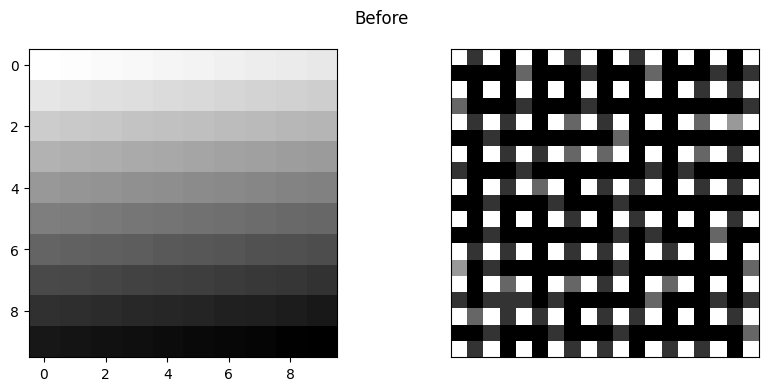

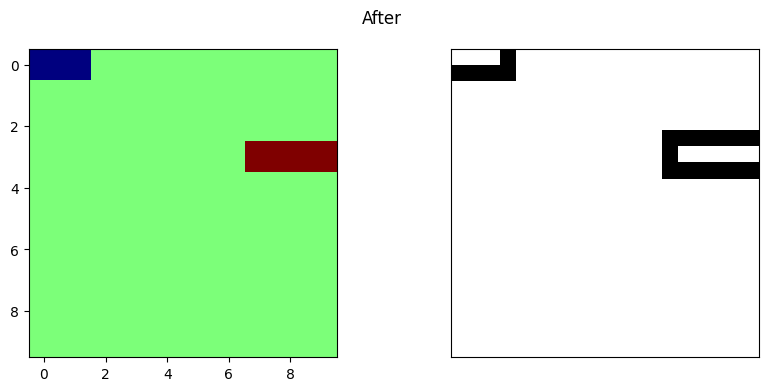

In [13]:
# Example of the simulation with technological developement
x = TechDevelopementAxelrodModel(L=10,seed=692137,developement_time=100)
x.createSystem()
plt.figure(figsize=(10,4))
plt.suptitle('Before')
plt.subplot(1,2,1)
x.plotMap()
plt.subplot(1,2,2)
x.plotBorders()
plt.show()
x.simulateUntilStable()
plt.figure(figsize=(10,4))
plt.suptitle('After')
plt.subplot(1,2,1)
a = x.plotMap('jet')
plt.subplot(1,2,2)
b = x.plotBorders()
plt.show()

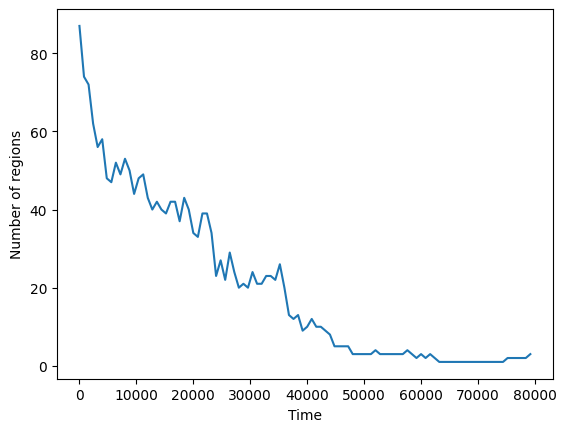

In [14]:
x = TechDevelopementAxelrodModel(seed=692137,developement_time=700)
x.createSystem()
c = []
for i in range(100): 
    progressBar(i,100,10)
    x.simulate(800,progress=False)
    c.append(x.countRegions())

plt.plot(np.arange(0,80000,800),c)
plt.xlabel('Time')
plt.ylabel('Number of regions')
plt.show()

In [15]:
x.n_traits

42

In [ ]:
# Time needed for stability
Ls = [4,6,8,10,12,14,16,18,20]
Ls2 = np.random.permutation(Ls)

def process(L):
    M = 10 if L < 15 else 10
    r = 0
    for _ in range(M):
        m = TechDevelopementAxelrodModel(L,5,10,developement_time=1000)
        m.createSystem()
        r += m.simulateUntilStable(10000000,1000)
    return r / M
        
results = Parallel(4)(delayed(process)(L) for L in Ls2)


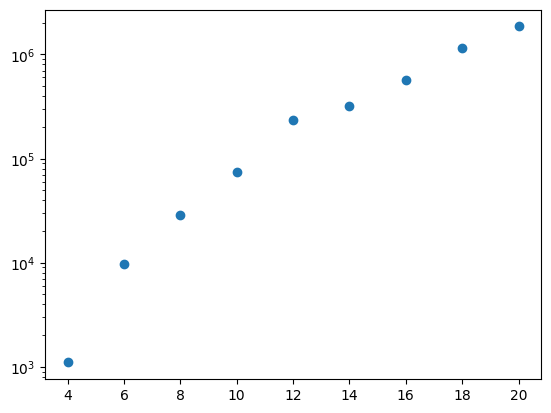

In [18]:
plt.plot(Ls2,results,'o')
plt.yscale('log')
plt.show()

In [17]:
z = np.array((sorted(zip(Ls2,results),key=lambda x: x[0])))
np.savetxt('tech1000_stability_time_F5_q10.txt',z)

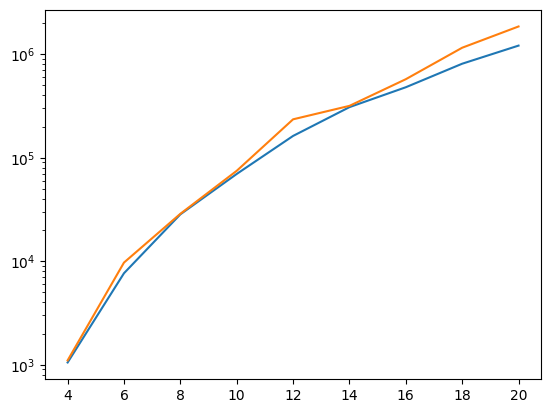

In [25]:
p1 = np.loadtxt('stability_time_F5_q10.txt')
p2 = np.loadtxt('tech1000_stability_time_F5_q10.txt')
plt.plot(p1[:,0],p1[:,1])
plt.plot(p2[:,0],p2[:,1])
plt.yscale('log')

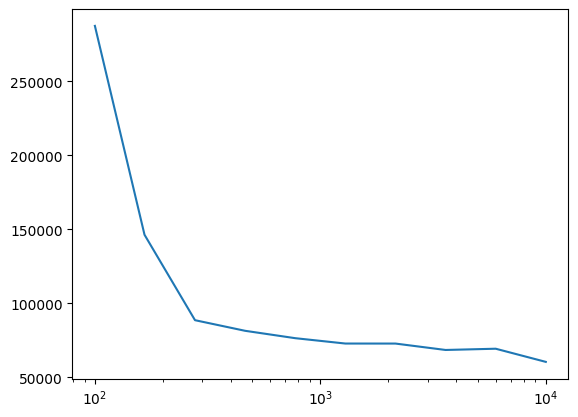

In [50]:
ts = np.logspace(2,4,10).astype(np.int32)
M = 40

def process(t):
    r = 0
    for _ in range(M):
        x = TechDevelopementAxelrodModel(10,5,5,developement_time=t)
        x.createSystem()
        r += x.simulateUntilStable(1000000,t)
    return r / M

results = Parallel(4)(delayed(process)(t) for t in ts)

plt.plot(ts,results)
plt.xscale('log')
plt.show()

In [51]:
z = np.array((sorted(zip(ts,results),key=lambda x: x[0])))
np.savetxt('tech_t_stability_time_F5.txt',z)

In [59]:
qs = np.arange(4,40,4)
D = np.zeros(len(qs))
nD = np.zeros(len(qs))
M = 10
L = 10

def process(q):
    print(q)
    res1 = 0
    res2 = 0
    for _ in range(M):
        m = TechDevelopementAxelrodModel(L,5,10)
        m.createSystem()
        m.simulateUntilStable()
        tmp = m.getRegions()
        res1 += max(tmp.values())
        res2 += len(tmp)
    return res1, res2

results = Parallel(n_jobs=4)(delayed(process)(q) for q in qs)

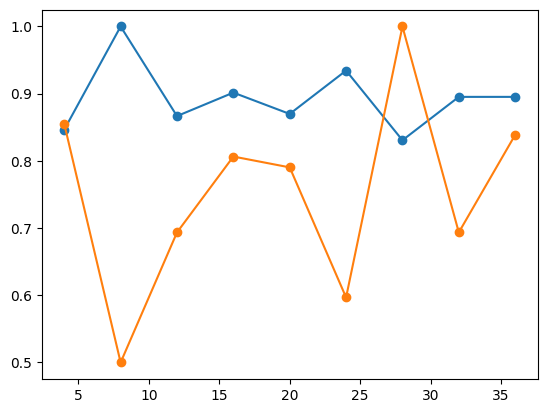

In [60]:
D = np.array(results,np.float64)[:,0]
nD = np.array(results,np.float64)[:,1]
D /= max(D)
nD /= max(nD)

import pandas as pd
x = pd.DataFrame({'q':qs, 'D':D, 'nD': nD})
x.to_csv('tech1000_phasetrans_L5_F5_M80.csv')

plt.plot(qs,D,'o-')
plt.plot(qs,nD,'o-')
plt.show()

## Geographical differences

In [41]:
# Model with geographical differences

class GeographicalAxelrodModel(BasicAxelrodModel):
    '''
    Introduce nonrandom starting site values - let a geographical region be a site with all the same features ex. 11111
    '''

    def __init__(self, L: int = 10, n_features: int = 5, n_traits: int = 10, site_class = Site, seed: int = None,verbose=False, n_regions: float = 5, subgrid = False):
        super().__init__(L, n_features, n_traits,site_class, seed)
        if(n_regions > self.n_traits):
            print(f'Number of regions exceeds number of traits and was set to {self.n_traits}')
            n_regions = self.n_traits
        self._n_regions = n_regions
        self._subgrid = subgrid
        

    def createSystem(self):  # Modified system creation to allow only selected regions to exist
        
        if self._subgrid: # If subgrid True then split the lattice into equal chunks of set regions

            if self.L%self._n_regions == 0: # If system is splittable into chunks

                chunk_size = int(self.L/self._n_regions) # Get chunk size

                self._system = np.empty((self._n_regions,self.L*chunk_size), dtype=self._site_class) # Create new divided system template with empty sites

                regions = [np.random.choice(self.n_traits,self.n_features) for x in range(self._n_regions)] # Get preset regions

                for i in range(len(self._system)): # Initialize each chunk separately
                    generator = np.vectorize(lambda _ : self._site_class(self.n_features,self.n_traits,values=regions[i]))
                    self._system[i] = generator(self._system[i])
                self._system = self._system.reshape(self.L,self.L) # Reshape system back to the LxL lattice

            else:
                raise Exception(f'Created {self.L} x {self.L} lattice cannot be equally split into {self._n_regions} regions!')

        else: # If subgrid False then randomly distribute the set regions

            regions = [np.random.choice(self.n_traits,5) for x in range(self._n_regions)] # Preset regions that are allowed in the initial system

            # Generator - a function asssinging to each element of system a new instance of Site class with given parameters
            generator = np.vectorize(lambda _ : self._site_class(self.n_features,self.n_traits,values=regions[np.random.choice(len(regions))]))
            # Creting a system
            self._system = generator(self._system)
    

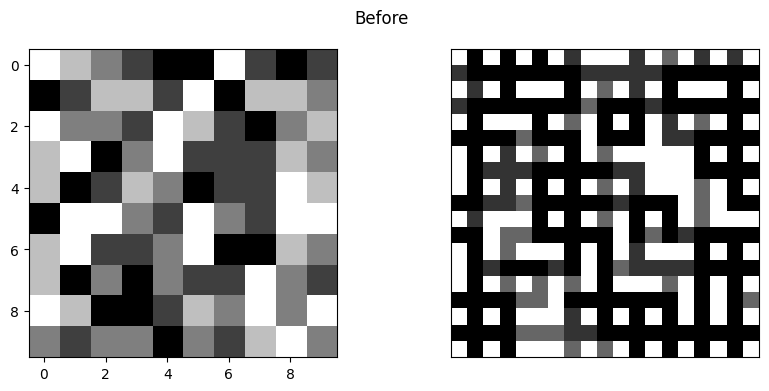

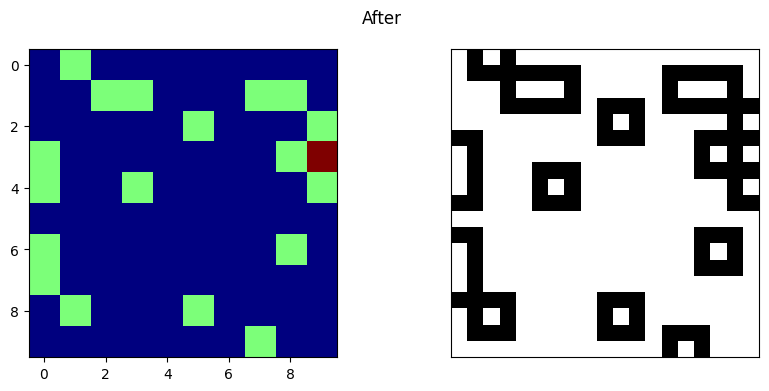

In [33]:
# Example of the simulation with geographical regions
x = GeographicalAxelrodModel(L=10,seed=692137,n_regions=5, verbose=True)
x.createSystem()
plt.figure(figsize=(10,4))
plt.suptitle('Before')
plt.subplot(1,2,1)
x.plotMap()
plt.subplot(1,2,2)
x.plotBorders()
plt.show()
x.simulate(80000)
plt.figure(figsize=(10,4))
plt.suptitle('After')
plt.subplot(1,2,1)
a = x.plotMap('jet')
plt.subplot(1,2,2)
b = x.plotBorders()
plt.show()

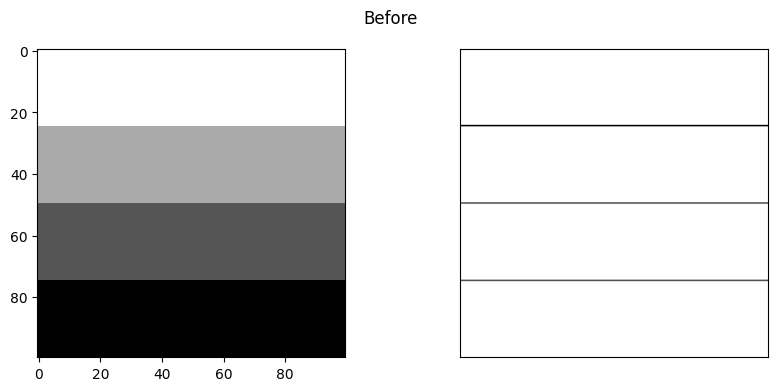

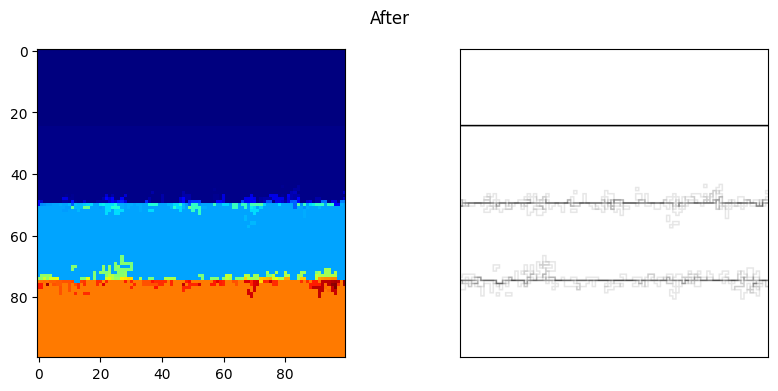

In [43]:
# Example of the simulation with geographical regions with distinct region border
x = GeographicalAxelrodModel(L=100,n_regions=4, verbose=True, subgrid=True, n_features=10, n_traits=5)
x.createSystem()
plt.figure(figsize=(10,4))
plt.suptitle('Before')
plt.subplot(1,2,1)
x.plotMap()
plt.subplot(1,2,2)
x.plotBorders()
plt.show()
x.simulate(200000)
plt.figure(figsize=(10,4))
plt.suptitle('After')
plt.subplot(1,2,1)
a = x.plotMap('jet')
plt.subplot(1,2,2)
b = x.plotBorders()
plt.show()

In [57]:
x.countRegions()


363

[array([7, 0, 5, 0, 1]), array([3, 5, 5, 6, 0])]


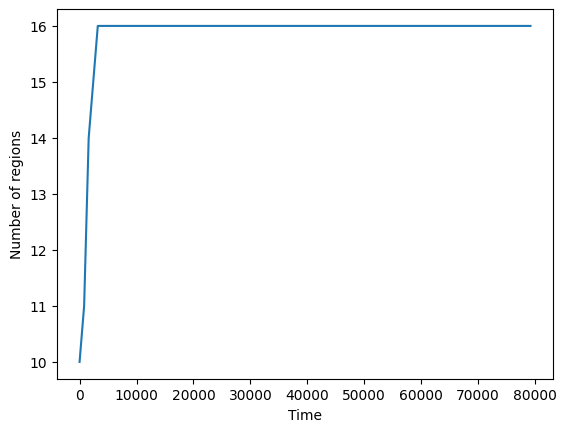

In [157]:
x = GeographicalAxelrodModel(L=100,seed=692137,n_regions=2)
x.createSystem()
c = []
for i in range(100): 
    progressBar(i,100,10)
    x.simulate(800,progress=False)
    c.append(x.countRegions())

plt.plot(np.arange(0,80000,800),c)
plt.xlabel('Time')
plt.ylabel('Number of regions')
plt.show()